# **World Cup 2018 Prediction**

The purpose of this is to try and predict the top 3 teams for World Cup 2018 using classification models coupled with poisson distribution to predict the exact results of the semi-finals, third place playoff and final. 

**Contents**
**1.** 

# **1. Import necessary packages/datasets**

In [1]:
%matplotlib inline 
import random
import numpy as np 
import scipy as sp 
from scipy.stats import poisson
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
direc = "/home/angps/Documents/WorldCupPrediction/dataset/"
cleaned_direc = "/home/angps/Documents/WorldCupPrediction/cleaned dataset/"
countries = pd.read_csv(direc + "01 2018 World Cup Team Statistics.csv")
historical = pd.read_csv(direc + "02 Historical Data on World Cup Matches.csv")
player_stats_18 = pd.read_csv(direc + "03 2018 FIFA Players Database.csv")
results = pd.read_csv(cleaned_direc + "cleaned_matches.csv")
squads = pd.read_csv(direc + "2018 FIFA World Cup Squads.csv")
fifa18 = pd.read_csv(direc + "complete.csv")
results_so_far = pd.read_csv(direc + '05 2018 World Cup Match Fixtures.csv')
stats = pd.read_csv(direc + '01 2018 World Cup Team Statistics.csv')
world_cup = pd.read_csv(direc + 'World Cup 2018 Dataset.csv')

# **2. Data Cleaning**

In [3]:
squads.Player = squads.Player.apply(lambda x: x[:-10] if "captain" in x else x)

In [4]:
fifa18 = fifa18.replace({"Korea Republic":"South Korea"})
wc_player_stats_18 = fifa18[fifa18["name"].isin(squads.Player) | fifa18["full_name"].isin(squads.Player)]
wc_fifa18_stats = fifa18[fifa18.nationality.isin(squads.Team)]

Updated Results as at 21/06

In [5]:
results_so_far["Result"] = np.where(results_so_far["Home Team Goals"] < results_so_far["Away Team Goals"], 0, np.where(results_so_far["Home Team Goals"]==results_so_far["Away Team Goals"],1,2))
results_so_far["Matches"] = results_so_far["Home Team Name"] + "," + results_so_far["Away Team Name"]
results_so_far = results_so_far.dropna(how="any")
results_so_far = results_so_far.drop(["Year","Match date","Stage","Stadium","Group"],axis=1)
results_so_far["Home Team Goals"] = results_so_far["Home Team Goals"].apply(lambda x: int(x))
results_so_far["Away Team Goals"] = results_so_far["Away Team Goals"].apply(lambda x: int(x))
results_so_far

,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Result,Matches
0,Russia,5,0,Saudi Arabia,2,"Russia,Saudi Arabia"
1,Egypt,0,1,Uruguay,0,"Egypt,Uruguay"
2,Morocco,0,1,Iran,0,"Morocco,Iran"
3,Portugal,3,3,Spain,1,"Portugal,Spain"
4,France,2,1,Australia,2,"France,Australia"
5,Argentina,1,1,Iceland,1,"Argentina,Iceland"
6,Peru,0,1,Denmark,0,"Peru,Denmark"
7,Croatia,2,0,Nigeria,2,"Croatia,Nigeria"
8,Costa Rica,0,1,Serbia,0,"Costa Rica,Serbia"
9,Germany,0,1,Mexico,0,"Germany,Mexico"


In [6]:
results = results.drop(["Unnamed: 0"],axis=1)
results.reset_index(inplace=True,drop=True)
results.tail()

,date,home_team,away_team,home_score,away_score,country,neutral,impt,home_ranking,home_total_points,home_prev_points,home_rank_change,home_cur_year_avg_weighted,home_last_year_avg_weighted,home_2_year_avg_weighted,home_3_year_avg_weighted,away_ranking,away_total_points,away_prev_points,away_rank_change,away_cur_year_avg_weighted,away_last_year_avg_weighted,away_2_year_avg_weighted,away_3_year_avg_weighted,diff_in_ranking,home_mean_weighted_over_years,away_mean_weighted_over_years,diff_in_mean_weighted_over_years,Result
451,2018-06,Denmark,Mexico,2,0,2,0,0,12.0,1051.44,1054.0,0.0,723.72,157.44,90.07,80.21,15.0,989.44,1008.0,0.0,470.55,253.39,173.99,91.51,-3.0,262.8600,247.3600,15.5000,2
452,2018-06,Sweden,Peru,0,0,2,0,0,24.0,879.90,889.0,-1.0,478.44,215.99,111.03,74.44,11.0,1125.39,1106.0,0.0,560.36,394.05,126.58,44.40,13.0,219.9750,281.3475,-61.3725,1
453,2018-06,Tunisia,Spain,1,0,0,1,0,21.0,909.91,1012.0,-7.0,545.56,197.39,68.28,98.68,10.0,1125.50,1162.0,-2.0,537.05,305.74,193.92,88.80,11.0,227.4775,281.3775,-53.9000,2
454,2018-06,South Korea,Senegal,0,2,0,1,0,57.0,543.67,520.0,4.0,162.13,223.79,91.79,65.96,27.0,837.98,825.0,1.0,368.23,268.67,84.09,116.99,30.0,135.9175,209.4950,-73.5775,0
455,2018-06,Belgium,Costa Rica,4,1,2,0,0,3.0,1298.32,1346.0,0.0,629.98,322.82,158.94,186.58,23.0,884.04,858.0,2.0,410.90,240.29,99.73,133.11,-20.0,324.5800,221.0075,103.5725,2


In [7]:
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "South Korea"})
world_cup = world_cup.set_index('Team')
world_cup.head(4)

,Group,First match against,Second match against,Third match against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia


In [8]:
wc_countries = countries[countries.team.isin(squads.Team)]
wc_countries.head()

,team,team_code,group,Soccer_power_index,Offence_rating,Defence_rating,Average_age,Average_height,june_fifa_rank,june_fifa_points,all_time_fifa_ranking,total_world_cup_points,total_world_cup_matches_played,total_worldcup_match_wins,total_worldcup_match_draws,total_worldcup_match_losses,total_worldcup_match_goals_scored,total_worldcup_match_goals_against,total_worldcup_match_average_points,total_worldcup_appearances
0,Argentina,ARG,D,87.14876,2.57571,0.40808,28.4,179.4,5,1241,4.0,140.0,77.0,42.0,14.0,21.0,131.0,84.0,1.8,16.0
1,Australia,AUS,C,62.52712,1.80032,1.01758,26.9,181.3,36,718,46.0,9.0,13.0,2.0,3.0,8.0,11.0,26.0,0.7,4.0
2,Belgium,BEL,G,85.40682,2.81096,0.63262,27.0,183.8,3,1298,14.0,51.0,41.0,14.0,9.0,18.0,52.0,66.0,1.1,12.0
3,Brazil,BRA,E,92.39264,3.05704,0.31349,27.8,180.4,2,1431,1.0,227.0,104.0,70.0,17.0,17.0,221.0,102.0,2.2,20.0
4,Colombia,COL,H,80.52894,2.18240,0.51246,27.3,180.2,16,986,28.0,23.0,18.0,7.0,2.0,9.0,26.0,27.0,1.3,5.0


In [9]:
squads = pd.read_csv(direc + '2018 FIFA World Cup Squads.csv')
rankings = pd.read_csv(direc + 'fifa_ranking.csv')

rankings_prev = rankings[rankings["rank_date"]=="2018-05-17"]
rankings_prev = rankings_prev.replace({"IR Iran":"Iran","Korea Republic":"South Korea"})
rankings_prev = rankings_prev.loc[rankings_prev["country_full"].isin(list(squads["Team"]))]
rankings_prev=rankings_prev.drop(["country_abrv","confederation"],axis=1)
rankings_prev.reset_index(inplace=True,drop=True)
rankings_prev = rankings_prev.set_index("country_full",drop=True)

rankings_18 = rankings[rankings["rank_date"]=="2018-06-07"]
rankings_18 = rankings_18.replace({"IR Iran":"Iran","Korea Republic":"South Korea"})
rankings_18 = rankings_18.loc[rankings_18["country_full"].isin(list(squads["Team"]))]
rankings_18=rankings_18.drop(["country_abrv","confederation"],axis=1)
rankings_18.reset_index(inplace=True,drop=True)
rankings_18 = rankings_18.set_index("country_full",drop=False)

rankings_18["mean_weighted_over_years"] = (rankings_18["cur_year_avg_weighted"]+rankings_18["last_year_avg_weighted"]+
                                            rankings_18["two_year_ago_weighted"]+rankings_18["three_year_ago_weighted"])/4
rankings_18.head()

,rank,country_full,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,rank_date,mean_weighted_over_years
country_full,,,,,,,,,,,,,,,
Germany,1,Germany,1558.49,1544,0,775.06,775.06,832.00,416.00,424.26,127.28,1200.77,240.15,2018-06-07,389.6225
Brazil,2,Brazil,1430.57,1384,0,558.95,558.95,1082.36,541.18,560.21,168.06,811.88,162.38,2018-06-07,357.6425
Belgium,3,Belgium,1298.32,1346,0,629.98,629.98,645.63,322.82,529.80,158.94,932.92,186.58,2018-06-07,324.5800
Portugal,4,Portugal,1273.69,1306,0,646.92,646.92,691.82,345.91,517.77,155.33,627.63,125.53,2018-06-07,318.4225
Argentina,5,Argentina,1241.45,1254,0,404.07,404.07,809.59,404.80,829.98,248.99,917.94,183.59,2018-06-07,310.3625


In [10]:
x = results.loc[:,["country","impt","home_rank_change","away_rank_change","diff_in_ranking","diff_in_mean_weighted_over_years"]]
y = results.loc[:,"Result"]

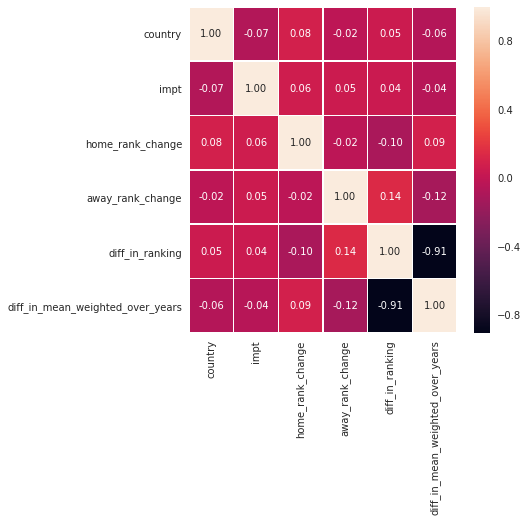

In [11]:
f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(x.corr(), annot=True, linewidths=0.5, fmt= '.2f',ax=ax)

# **3. Classification Models to predict match results (Win/Draw/Lose)**

# **3.1 Splitting into training and test set**

We shall use 80% of our dataset as our training set and 20% as our test set. We will also apply 5-fold Cross Validation

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [13]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

Let's define some function to evaluate our models

In [14]:
def train_acc_score(model):
    return round(np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy")),2)

def test_acc_score(model):
    return round(accuracy_score(y_test, model.predict(x_test)),2)

def train_prec_score(model):
    return round(precision_score(y_train,model.predict(x_train),average='macro'),2)

def test_prec_score(model):
    return round(precision_score(y_test,model.predict(x_test),average='macro'),2)

def train_f1(model):
    return round(f1_score(y_train,model.predict(x_train),average='macro'),2)

def test_f1(model):
    return round(f1_score(y_test,model.predict(x_test),average='macro'),2)

def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
    cm.index=["Actual Away Win","Actual Draw","Actual Home Win"]
    return cm.T

def confusion_matrix_model_train(model_used):
    cm=confusion_matrix(y_train,model_used.predict(x_train))
    col=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
    cm.index=["Actual Away Win","Actual Draw","Actual Home Win"]
    return cm.T

def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(6,6))

# **3.2 Building classification models to predict results**

The models will be optimised using GridSearchCV based on F1 score. F1 score gives a weighted average between precision and accuracy/recall. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).

I have typed in some of the optimised parameters based on the GridSearchCV code output, then commented out the GridSearchCV codes to make the notebook run faster as it won't be re-optimised.

**3.2.1. Logistic Regression (Lasso)**

In [15]:
param_grid = dict(C=(0.0001,0.001,0.005,0.01,0.1,0.5,1))
log_reg1 = GridSearchCV(LogisticRegression(penalty="l1"),param_grid=param_grid,scoring="f1_macro")
#log_reg1=LogisticRegression(penalty="l1")
log_reg1.fit(x_train,y_train)
print(log_reg1.best_params_)
print("In-sample accuracy: " + str(train_acc_score(log_reg1)))
print("Test accuracy: " + str(test_acc_score(log_reg1)))
print ("In-sample Precision Score: " + str(train_prec_score(log_reg1)))
print ("Test Precision Score: " + str(test_prec_score(log_reg1)))
print ("In-sample F1 Score: " + str(train_f1(log_reg1)))
print ("Test F1 Score: " + str(test_f1(log_reg1)))
confusion_matrix_model_train(log_reg1)

{'C': 0.5}
In-sample accuracy: 0.58
Test accuracy: 0.48
In-sample Precision Score: 0.64
Test Precision Score: 0.3
In-sample F1 Score: 0.47
Test F1 Score: 0.35


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,63,30,21
Predicted Draw,1,6,1
Predicted Home Win,46,46,150


**3.2.2. Logistic Regression (Ridge)**

In [16]:
param_grid = dict(C=(0.0001,0.001,0.005,0.01,0.1,0.5,1))
log_reg2 = GridSearchCV(LogisticRegression(penalty="l2"),param_grid=param_grid,scoring="f1_macro")
#log_reg2=LogisticRegression(penalty="l2",C=0.01)
log_reg2.fit(x_train,y_train)
print(log_reg2.best_params_)
print("In-sample accuracy: " + str(train_acc_score(log_reg2)))
print("Test accuracy: " + str(test_acc_score(log_reg2)))
print ("In-sample Precision Score: " + str(train_prec_score(log_reg2)))
print ("Test Precision Score: " + str(test_prec_score(log_reg2)))
print ("In-sample F1 Score: " + str(train_f1(log_reg2)))
print ("Test F1 Score: " + str(test_f1(log_reg2)))
confusion_matrix_model_train(log_reg2)

{'C': 0.5}
In-sample accuracy: 0.59
Test accuracy: 0.46
In-sample Precision Score: 0.57
Test Precision Score: 0.28
In-sample F1 Score: 0.47
Test F1 Score: 0.33


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,63,30,20
Predicted Draw,2,6,3
Predicted Home Win,45,46,149


**3.2.3. SVM (RBF Kernel)**

In [17]:
#param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2),gamma=(0.001,0.01,0.1,0.5,1,2))
#svc_rbf = GridSearchCV(SVC(kernel="rbf",random_state=0),param_grid=param_grid,scoring="f1_macro")
svc_rbf = SVC(kernel='rbf', gamma=0.001, C=0.5,random_state=0)
svc_rbf.fit(x_train, y_train)
#print(svc_rbf.best_params_)
print("In-sample accuracy: " + str(train_acc_score(svc_rbf)))
print("Test accuracy: " + str(test_acc_score(svc_rbf)))
print ("In-sample Precision Score: " + str(train_prec_score(svc_rbf)))
print ("Test Precision Score: " + str(test_prec_score(svc_rbf)))
print ("In-sample F1 Score: " + str(train_f1(svc_rbf)))
print ("Test F1 Score: " + str(test_f1(svc_rbf)))
confusion_matrix_model_train(svc_rbf)

In-sample accuracy: 0.55
Test accuracy: 0.47
In-sample Precision Score: 0.38
Test Precision Score: 0.29
In-sample F1 Score: 0.42
Test F1 Score: 0.34


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,57,29,18
Predicted Draw,0,0,0
Predicted Home Win,53,53,154


**3.2.4. SVM (Linear Kernel)**

In [18]:
#param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2),gamma=(0.001,0.01,0.1,0.5,1,2))
#svc_lin= GridSearchCV(SVC(kernel="linear",random_state=0),param_grid=param_grid,scoring="f1_macro")
svc_lin = SVC(kernel='linear', gamma=0.001, C=0.1,random_state=0)
svc_lin.fit(x_train, y_train)
#print(svc_lin.best_params_)
print("In-sample accuracy: " + str(train_acc_score(svc_lin)))
print("Test accuracy: " + str(test_acc_score(svc_lin)))
print ("In-sample Precision Score: " + str(train_prec_score(svc_lin)))
print ("Test Precision Score: " + str(test_prec_score(svc_lin)))
print ("In-sample F1 Score: " + str(train_f1(svc_lin)))
print ("Test F1 Score: " + str(test_f1(svc_lin)))
confusion_matrix_model_train(svc_lin)

In-sample accuracy: 0.56
Test accuracy: 0.5
In-sample Precision Score: 0.72
Test Precision Score: 0.31
In-sample F1 Score: 0.46
Test F1 Score: 0.37


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,65,34,24
Predicted Draw,0,4,0
Predicted Home Win,45,44,148


**3.2.5. K-Nearest Neighbour**

In [19]:
#param_grid = dict(n_neighbors=np.arange(10,70),weights=("uniform","distance"),p=(1,2))
#KNN = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,scoring="f1_macro")
KNN=KNeighborsClassifier(n_neighbors=16,p=1,weights='uniform')
KNN.fit(x_train,y_train)
#print(KNN.best_params_)
print("In-sample accuracy: " + str(train_acc_score(KNN)))
print("Test accuracy: " + str(test_acc_score(KNN)))
print ("In-sample Precision Score: " + str(train_prec_score(KNN)))
print ("Test Precision Score: " + str(test_prec_score(KNN)))
print ("In-sample F1 Score: " + str(train_f1(KNN)))
print ("Test F1 Score: " + str(test_f1(KNN)))
confusion_matrix_model_train(KNN)

In-sample accuracy: 0.54
Test accuracy: 0.46
In-sample Precision Score: 0.54
Test Precision Score: 0.34
In-sample F1 Score: 0.5
Test F1 Score: 0.35


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,62,31,18
Predicted Draw,9,11,7
Predicted Home Win,39,40,147


**3.2.6. Decision Tree**

In [20]:
#param_grid = dict(max_depth=np.arange(4,10),min_samples_leaf=np.arange(1,8),min_samples_split=np.arange(2,8),max_leaf_nodes=np.arange(30,100,10))
#Dec_tree = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,scoring="f1_macro")
Dec_tree=DecisionTreeClassifier(max_depth= 8, max_leaf_nodes= 40, min_samples_leaf= 1, min_samples_split= 7)
Dec_tree.fit(x_train,y_train)
#print(Dec_tree.best_params_)
print("In-sample accuracy: " + str(train_acc_score(Dec_tree)))
print("Test accuracy: " + str(test_acc_score(Dec_tree)))
print ("In-sample Precision Score: " + str(train_prec_score(Dec_tree)))
print ("Test Precision Score: " + str(test_prec_score(Dec_tree)))
print ("In-sample F1 Score: " + str(train_f1(Dec_tree)))
print ("Test F1 Score: " + str(test_f1(Dec_tree)))
confusion_matrix_model_train(Dec_tree)

In-sample accuracy: 0.43
Test accuracy: 0.45
In-sample Precision Score: 0.77
Test Precision Score: 0.38
In-sample F1 Score: 0.75
Test F1 Score: 0.37


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,75,12,7
Predicted Draw,6,53,13
Predicted Home Win,29,17,152


**3.2.7. Random Forest**

In [21]:
#param_grid = dict(max_depth=np.arange(3,10),min_samples_leaf=np.arange(1,10),min_samples_split=np.arange(2,6),max_leaf_nodes=np.arange(50,120,10))
#param_grid = dict(n_estimators = np.arange(50,500,50))
#ranfor = GridSearchCV(RandomForestClassifier(max_depth= 7, max_leaf_nodes=50, min_samples_leaf= 7, min_samples_split= 4,random_state=0),param_grid=param_grid,scoring="f1_macro")
ranfor = RandomForestClassifier(n_estimators=50,max_depth= 7, max_leaf_nodes=50, min_samples_leaf= 7, min_samples_split= 4,random_state=0)
ranfor.fit(x_train,y_train)
#print(ranfor.best_params_)
print("In-sample accuracy: " + str(train_acc_score(ranfor)))
print("Test accuracy: " + str(test_acc_score(ranfor)))
print ("In-sample Precision Score: " + str(train_prec_score(ranfor)))
print ("Test Precision Score: " + str(test_prec_score(ranfor)))
print ("In-sample F1 Score: " + str(train_f1(ranfor)))
print ("Test F1 Score: " + str(test_f1(ranfor)))
confusion_matrix_model_train(ranfor)

In-sample accuracy: 0.55
Test accuracy: 0.49
In-sample Precision Score: 0.73
Test Precision Score: 0.42
In-sample F1 Score: 0.55
Test F1 Score: 0.38


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,74,26,19
Predicted Draw,1,11,0
Predicted Home Win,35,45,153


**3.2.8. XGBoosting**

In [22]:
#param_grid = dict(n_estimators=np.arange(50,500,50),max_depth=np.arange(6,12),learning_rate=(0.0001,0.001,0.01,0.1))
#xgclass = GridSearchCV(xgb.XGBClassifier(random_state=0),param_grid=param_grid,scoring="f1_macro")
xgclass = xgb.XGBClassifier(max_depth=9, n_estimators=450, learning_rate=0.01)
xgclass.fit(x_train,y_train)
#print(xgclass.best_params_)
print("In-sample accuracy: " + str(train_acc_score(xgclass)))
print("Test accuracy: " + str(test_acc_score(xgclass)))
print ("In-sample Precision Score: " + str(train_prec_score(xgclass)))
print ("Test Precision Score: " + str(test_prec_score(xgclass)))
print ("In-sample F1 Score: " + str(train_f1(xgclass)))
print ("Test F1 Score: " + str(test_f1(xgclass)))
confusion_matrix_model_train(xgclass)

In-sample accuracy: 0.49
Test accuracy: 0.52
In-sample Precision Score: 0.99
Test Precision Score: 0.5
In-sample F1 Score: 0.98
Test F1 Score: 0.48


,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,110,0,0
Predicted Draw,0,78,1
Predicted Home Win,0,4,171


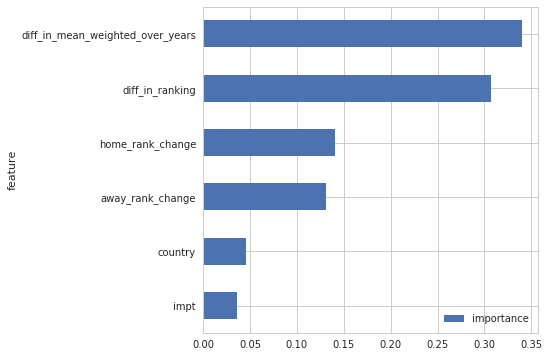

In [23]:
importance_of_features(xgclass)

# **3.3 Evaluation for models predicting results**

In [24]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine (RBF)","Support Vector Machine(Linear)","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[round(train_acc_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,svc_lin,KNN,Dec_tree,ranfor,xgclass]]
test_acc=[round(test_acc_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,svc_lin,KNN,Dec_tree,ranfor,xgclass]]
train_prec = [round(train_prec_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,svc_lin,KNN,Dec_tree,ranfor,xgclass]]
test_prec = [round(test_prec_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,svc_lin,KNN,Dec_tree,ranfor,xgclass]]
trainf1 = [train_f1(x) for x in [log_reg1,log_reg2,svc_rbf,svc_lin,KNN,Dec_tree,ranfor,xgclass]]
testf1 = [test_f1(x) for x in [log_reg1,log_reg2,svc_rbf,svc_lin,KNN,Dec_tree,ranfor,xgclass]]
cols=["Classifier","Training Accuracy","Test Accuracy","Training Precision","Test Precision","Training F1 Score","Test F1 Score"]
pred_results = pd.DataFrame(columns=cols)
pred_results["Classifier"]=Classifiers
pred_results["Training Accuracy"]=in_sample_acc
pred_results["Test Accuracy"]=test_acc
pred_results["Training Precision"]=train_prec
pred_results["Test Precision"]=test_prec
pred_results["Training F1 Score"]=trainf1
pred_results["Test F1 Score"]=testf1
pred_results

,Classifier,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training F1 Score,Test F1 Score
0,Logistic Regression (Lasso),0.58,0.48,0.64,0.30,0.47,0.35
1,Logistic Regression (Ridge),0.59,0.46,0.57,0.28,0.47,0.33
2,Support Vector Machine (RBF),0.55,0.47,0.38,0.29,0.42,0.34
3,Support Vector Machine(Linear),0.56,0.50,0.72,0.31,0.46,0.37
4,K-Nearest Neighbours,0.54,0.46,0.54,0.34,0.50,0.35
5,Decision Tree,0.43,0.45,0.77,0.38,0.75,0.37
6,Random Forest,0.55,0.49,0.73,0.42,0.55,0.38
7,XGBoost,0.49,0.52,0.99,0.50,0.98,0.48


**Selected model to predict W/D/L result: **

**XGBoost** --> Highest Test set F1 score, along with highest test set accuracy and precision 

# **4. Classification Models to predict exact goals scored by Home and Away Sides**

# **4.1 Splitting into training and test set**

Again, we will use 80-20 to split the training and test set with 5-fold cross validation. 

In [25]:
x = results.loc[:,["country","impt","home_rank_change","away_rank_change","diff_in_ranking","diff_in_mean_weighted_over_years"]]
y_home=results.loc[:,"home_score"]
y_away=results.loc[:,"away_score"]

In [26]:
x_home_train,x_home_test,y_home_train,y_home_test=train_test_split(x,y_home,test_size=0.2,random_state=0)
x_away_train,x_away_test,y_away_train,y_away_test=train_test_split(x,y_away,test_size=0.2,random_state=0)
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

Functions to evaluate the models for goals scored for home and away:

In [27]:
#home goals
def home_train_acc_score(model):
    return round(np.mean(cross_val_score(model,x_home_train,y_home_train,cv=k_fold,scoring="accuracy")),2)
def home_test_acc_score(model):
    return round(accuracy_score(y_home_test, model.predict(x_home_test)),2)
def home_train_prec_score(model):
    return round(precision_score(y_home_train,model.predict(x_home_train),average='macro'),2)
def home_test_prec_score(model):
    return round(precision_score(y_home_test,model.predict(x_home_test),average='macro'),2)
def home_train_f1(model):
    return round(f1_score(y_home_train,model.predict(x_home_train),average='macro'),2)
def home_test_f1(model):
    return round(f1_score(y_home_test,model.predict(x_home_test),average='macro'),2)
def home_confusion_matrix_model_train(model_used):
    cm=confusion_matrix(y_home_train,model_used.predict(x_home_train))
    col=["Predicted Home Goals: 0","Predicted Home Goals: 1","Predicted Home Goals: 2","Predicted Home Goals: 3","Predicted Home Goals: 4","Predicted Home Goals: 5","Predicted Home Goals: 6"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Home Goals: 0","Predicted Home Goals: 1","Predicted Home Goals: 2","Predicted Home Goals: 3","Predicted Home Goals: 4","Predicted Home Goals: 5","Predicted Home Goals: 6"]
    cm.index=["Actual Home Goals: 0","Actual Home Goals: 1","Actual Home Goals: 2","Actual Home Goals: 3","Actual Home Goals: 4","Actual Home Goals: 5","Actual Home Goals: 6"]
    #cm[col]=np(cm[col])
    return cm.T
def home_confusion_matrix_model_test(model_used):
    cm=confusion_matrix(y_home_test,model_used.predict(x_home_test))
    col=["Predicted Home Goals: 0","Predicted Home Goals: 1","Predicted Home Goals: 2","Predicted Home Goals: 3","Predicted Home Goals: 4","Predicted Home Goals: 5","Predicted Home Goals: 6"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Home Goals: 0","Predicted Home Goals: 1","Predicted Home Goals: 2","Predicted Home Goals: 3","Predicted Home Goals: 4","Predicted Home Goals: 5","Predicted Home Goals: 6"]
    cm.index=["Actual Home Goals: 0","Actual Home Goals: 1","Actual Home Goals: 2","Actual Home Goals: 3","Actual Home Goals: 4","Actual Home Goals: 5","Actual Home Goals: 6"]
    #cm[col]=np(cm[col])
    return cm.T
def home_importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_home_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

#away goals
def away_train_acc_score(model):
    return round(np.mean(cross_val_score(model,x_away_train,y_away_train,cv=k_fold,scoring="accuracy")),2)
def away_test_acc_score(model):
    return round(accuracy_score(y_away_test, model.predict(x_away_test)),2)
def away_train_prec_score(model):
    return round(precision_score(y_away_train,model.predict(x_away_train),average='macro'),2)
def away_test_prec_score(model):
    return round(precision_score(y_away_test,model.predict(x_away_test),average='macro'),2)
def away_train_f1(model):
    return round(f1_score(y_away_train,model.predict(x_away_train),average='macro'),2)
def away_test_f1(model):
    return round(f1_score(y_away_test,model.predict(x_away_test),average='macro'),2)
def away_confusion_matrix_model_train(model_used):
    cm=confusion_matrix(y_away_train,model_used.predict(x_away_train))
    col=["Predicted Away Goals: 0","Predicted Away Goals: 1","Predicted Away Goals: 2","Predicted Away Goals: 3","Predicted Away Goals: 4","Predicted Away Goals: 5","Predicted Away Goals: 6"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Away Goals: 0","Predicted Away Goals: 1","Predicted Away Goals: 2","Predicted Away Goals: 3","Predicted Away Goals: 4","Predicted Away Goals: 5","Predicted Away Goals: 6"]
    cm.index=["Actual Away Goals: 0","Actual Away Goals: 1","Actual Away Goals: 2","Actual Away Goals: 3","Actual Away Goals: 4","Actual Away Goals: 5","Actual Away Goals: 6"]
    #cm[col]=np(cm[col])
    return cm.T
def away_confusion_matrix_model_test(model_used):
    cm=confusion_matrix(y_away_test,model_used.predict(x_away_test))
    col=["Predicted Away Goals: 0","Predicted Away Goals: 1","Predicted Away Goals: 2","Predicted Away Goals: 3","Predicted Away Goals: 4","Predicted Away Goals: 5","Predicted Away Goals: 6"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Away Goals: 0","Predicted Away Goals: 1","Predicted Away Goals: 2","Predicted Away Goals: 3","Predicted Away Goals: 4","Predicted Away Goals: 5","Predicted Away Goals: 6"]
    cm.index=["Actual Away Goals: 0","Actual Away Goals: 1","Actual Away Goals: 2","Actual Away Goals: 3","Actual Away Goals: 4","Actual Away Goals: 5","Actual Away Goals: 6"]
    #cm[col]=np(cm[col])
    return cm.T
def away_importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_away_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

# **4.2 Classification models for goals scored by Home Side**

**4.2.1. Logistic Regression (Lasso)**

In [28]:
param_grid = dict(C=(0.0001,0.001,0.005,0.01,0.1,0.5,1))
homelog_reg1 = GridSearchCV(LogisticRegression(penalty="l1"),param_grid=param_grid,scoring="f1_macro")
#homelog_reg1=LogisticRegression(penalty="l1")
homelog_reg1.fit(x_home_train,y_home_train)
#predicted=log_reg1.predict(x_test)
print(homelog_reg1.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homelog_reg1)))
print("Test accuracy: " + str(home_test_acc_score(homelog_reg1)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homelog_reg1)))
print ("Test Precision Score: " + str(home_test_prec_score(homelog_reg1)))
print ("In-sample F1 Score: " + str(home_train_f1(homelog_reg1)))
print ("Test F1 Score: " + str(home_test_f1(homelog_reg1)))
home_confusion_matrix_model_train(homelog_reg1)

{'C': 0.1}
In-sample accuracy: 0.39
Test accuracy: 0.36
In-sample Precision Score: 0.33
Test Precision Score: 0.2
In-sample F1 Score: 0.19
Test F1 Score: 0.16


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,18,8,6,3,0,0,0
Predicted Home Goals: 1,54,83,43,18,6,0,1
Predicted Home Goals: 2,11,29,50,14,11,5,3
Predicted Home Goals: 3,0,0,0,1,0,0,0
Predicted Home Goals: 4,0,0,0,0,0,0,0
Predicted Home Goals: 5,0,0,0,0,0,0,0
Predicted Home Goals: 6,0,0,0,0,0,0,0


**4.2.2. Logistic Regression (Ridge)**

In [29]:
param_grid = dict(C=(0.0001,0.001,0.005,0.01,0.1,0.5,1))
homelog_reg2 = GridSearchCV(LogisticRegression(penalty="l2"),param_grid=param_grid,scoring="f1_macro")
#homelog_reg1=LogisticRegression(penalty="l1")
homelog_reg2.fit(x_home_train,y_home_train)
#predicted=log_reg1.predict(x_test)
print(homelog_reg2.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homelog_reg2)))
print("Test accuracy: " + str(home_test_acc_score(homelog_reg2)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homelog_reg2)))
print ("Test Precision Score: " + str(home_test_prec_score(homelog_reg2)))
print ("In-sample F1 Score: " + str(home_train_f1(homelog_reg2)))
print ("Test F1 Score: " + str(home_test_f1(homelog_reg2)))
home_confusion_matrix_model_train(homelog_reg2)

{'C': 0.01}
In-sample accuracy: 0.37
Test accuracy: 0.33
In-sample Precision Score: 0.25
Test Precision Score: 0.15
In-sample F1 Score: 0.19
Test F1 Score: 0.15


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,27,16,12,5,0,0,0
Predicted Home Goals: 1,39,63,29,12,6,0,1
Predicted Home Goals: 2,16,41,58,18,11,5,3
Predicted Home Goals: 3,1,0,0,1,0,0,0
Predicted Home Goals: 4,0,0,0,0,0,0,0
Predicted Home Goals: 5,0,0,0,0,0,0,0
Predicted Home Goals: 6,0,0,0,0,0,0,0


**4.2.3. SVM (RBF Kernel)**

In [30]:
#param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2),gamma=(0.001,0.01,0.1,0.5,1,2))
#homesvc_rbf = GridSearchCV(SVC(kernel="rbf",random_state=0),param_grid=param_grid,scoring="f1_macro")
homesvc_rbf = SVC(kernel='rbf', gamma=0.001, C=1,random_state=0)
homesvc_rbf.fit(x_home_train, y_home_train)
#print(homesvc_rbf.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homesvc_rbf)))
print("Test accuracy: " + str(home_test_acc_score(homesvc_rbf)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homesvc_rbf)))
print ("Test Precision Score: " + str(home_test_prec_score(homesvc_rbf)))
print ("In-sample F1 Score: " + str(home_train_f1(homesvc_rbf)))
print ("Test F1 Score: " + str(home_test_f1(homesvc_rbf)))
home_confusion_matrix_model_train(homesvc_rbf)

In-sample accuracy: 0.33
Test accuracy: 0.36
In-sample Precision Score: 0.44
Test Precision Score: 0.18
In-sample F1 Score: 0.26
Test F1 Score: 0.15


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,27,8,7,5,1,1,0
Predicted Home Goals: 1,43,93,51,22,12,1,1
Predicted Home Goals: 2,13,19,41,7,4,1,3
Predicted Home Goals: 3,0,0,0,2,0,1,0
Predicted Home Goals: 4,0,0,0,0,0,0,0
Predicted Home Goals: 5,0,0,0,0,0,1,0
Predicted Home Goals: 6,0,0,0,0,0,0,0


**4.2.4. KNN** 

In [31]:
#param_grid = dict(n_neighbors=np.arange(10,70),weights=("uniform","distance"),p=(1,2))
#homeKNN = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,scoring="f1_macro")
homeKNN=KNeighborsClassifier(n_neighbors=10,p=1,weights='uniform')
homeKNN.fit(x_home_train,y_home_train)
predicted=homeKNN.predict(x_home_test)
#print(homeKNN.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homeKNN)))
print("Test accuracy: " + str(home_test_acc_score(homeKNN)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homeKNN)))
print ("Test Precision Score: " + str(home_test_prec_score(homeKNN)))
print ("In-sample F1 Score: " + str(home_train_f1(homeKNN)))
print ("Test F1 Score: " + str(home_test_f1(homeKNN)))
home_confusion_matrix_model_train(homeKNN)

In-sample accuracy: 0.32
Test accuracy: 0.34
In-sample Precision Score: 0.36
Test Precision Score: 0.15
In-sample F1 Score: 0.25
Test F1 Score: 0.15


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,44,30,20,7,6,0,1
Predicted Home Goals: 1,27,74,43,19,6,1,1
Predicted Home Goals: 2,11,16,34,9,5,3,2
Predicted Home Goals: 3,1,0,2,1,0,0,0
Predicted Home Goals: 4,0,0,0,0,0,0,0
Predicted Home Goals: 5,0,0,0,0,0,1,0
Predicted Home Goals: 6,0,0,0,0,0,0,0


**4.2.5. Decision Tree**

In [32]:
#param_grid = dict(max_depth=np.arange(4,10),min_samples_leaf=np.arange(1,8),min_samples_split=np.arange(2,8),max_leaf_nodes=np.arange(30,100,10))
#homeDec_tree = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,scoring="f1_macro")
homeDec_tree=DecisionTreeClassifier(max_depth= 8, max_leaf_nodes= 50, min_samples_leaf= 1, min_samples_split= 6,random_state=0)
homeDec_tree.fit(x_home_train,y_home_train)
predicted=homeDec_tree.predict(x_home_test)
#print(homeDec_tree.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homeDec_tree)))
print("Test accuracy: " + str(home_test_acc_score(homeDec_tree)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homeDec_tree)))
print ("Test Precision Score: " + str(home_test_prec_score(homeDec_tree)))
print ("In-sample F1 Score: " + str(home_train_f1(homeDec_tree)))
print ("Test F1 Score: " + str(home_test_f1(homeDec_tree)))
home_confusion_matrix_model_train(homeDec_tree)

In-sample accuracy: 0.27
Test accuracy: 0.23
In-sample Precision Score: 0.61
Test Precision Score: 0.17
In-sample F1 Score: 0.42
Test F1 Score: 0.13


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,70,29,31,13,9,0,2
Predicted Home Goals: 1,9,84,14,7,0,0,1
Predicted Home Goals: 2,4,7,54,10,2,2,0
Predicted Home Goals: 3,0,0,0,5,1,3,0
Predicted Home Goals: 4,0,0,0,1,5,0,0
Predicted Home Goals: 5,0,0,0,0,0,0,0
Predicted Home Goals: 6,0,0,0,0,0,0,1


**4.2.6. Random Forest**

In [33]:
#param_grid = dict(max_depth=np.arange(3,10),min_samples_leaf=np.arange(1,10),min_samples_split=np.arange(2,6),max_leaf_nodes=np.arange(50,120,10))
#param_grid = dict(n_estimators = np.arange(50,500,50))
#homeranfor = GridSearchCV(RandomForestClassifier(max_depth= 4, max_leaf_nodes=50, min_samples_leaf= 1, min_samples_split= 3,random_state=0),param_grid=param_grid,scoring="f1_macro")
homeranfor = RandomForestClassifier(n_estimators=250,max_depth= 4, max_leaf_nodes=50, min_samples_leaf= 1, min_samples_split= 3,random_state=0)
homeranfor.fit(x_home_train,y_home_train)
predicted=homeranfor.predict(x_home_test)
#print(ranfor.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homeranfor)))
print("Test accuracy: " + str(home_test_acc_score(homeranfor)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homeranfor)))
print ("Test Precision Score: " + str(home_test_prec_score(homeranfor)))
print ("In-sample F1 Score: " + str(home_train_f1(homeranfor)))
print ("Test F1 Score: " + str(home_test_f1(homeranfor)))
home_confusion_matrix_model_train(homeranfor)

In-sample accuracy: 0.35
Test accuracy: 0.36
In-sample Precision Score: 0.68
Test Precision Score: 0.2
In-sample F1 Score: 0.38
Test F1 Score: 0.16


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,35,5,6,3,0,0,0
Predicted Home Goals: 1,29,98,28,15,9,0,1
Predicted Home Goals: 2,19,17,65,14,7,3,3
Predicted Home Goals: 3,0,0,0,4,0,0,0
Predicted Home Goals: 4,0,0,0,0,1,0,0
Predicted Home Goals: 5,0,0,0,0,0,2,0
Predicted Home Goals: 6,0,0,0,0,0,0,0


**4.2.7. XGBooost**

In [34]:
#param_grid = dict(n_estimators=np.arange(50,500,50),max_depth=np.arange(6,12),learning_rate=(0.0001,0.001,0.01,0.1))
#homexgclass = GridSearchCV(xgb.XGBClassifier(random_state=0),param_grid=param_grid,scoring="f1_macro")
homexgclass = xgb.XGBClassifier(max_depth=11, n_estimators=350, learning_rate=0.01)
homexgclass.fit(x_home_train,y_home_train)
predicted=homexgclass.predict(x_home_test)
#print(homexgclass.best_params_)
print("In-sample accuracy: " + str(home_train_acc_score(homexgclass)))
print("Test accuracy: " + str(home_test_acc_score(homexgclass)))
print ("In-sample Precision Score: " + str(home_train_prec_score(homexgclass)))
print ("Test Precision Score: " + str(home_test_prec_score(homexgclass)))
print ("In-sample F1 Score: " + str(home_train_f1(homexgclass)))
print ("Test F1 Score: " + str(home_test_f1(homexgclass)))
home_confusion_matrix_model_train(homexgclass)

In-sample accuracy: 0.24
Test accuracy: 0.24
In-sample Precision Score: 0.99
Test Precision Score: 0.18
In-sample F1 Score: 0.94
Test F1 Score: 0.18


,Actual Home Goals: 0,Actual Home Goals: 1,Actual Home Goals: 2,Actual Home Goals: 3,Actual Home Goals: 4,Actual Home Goals: 5,Actual Home Goals: 6
Predicted Home Goals: 0,83,0,0,0,0,0,0
Predicted Home Goals: 1,0,119,1,2,2,1,1
Predicted Home Goals: 2,0,1,98,0,0,0,0
Predicted Home Goals: 3,0,0,0,34,0,0,0
Predicted Home Goals: 4,0,0,0,0,15,0,0
Predicted Home Goals: 5,0,0,0,0,0,4,0
Predicted Home Goals: 6,0,0,0,0,0,0,3


# **4.3 Evaluation for Models predicting Home Goals**

In [35]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine (RBF)","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[round(home_train_acc_score(x),2) for x in [homelog_reg1,homelog_reg2,homesvc_rbf,homeKNN,homeDec_tree,homeranfor,homexgclass]]
test_acc=[round(home_test_acc_score(x),2) for x in [homelog_reg1,homelog_reg2,homesvc_rbf,homeKNN,homeDec_tree,homeranfor,homexgclass]]
train_prec = [round(home_train_prec_score(x),2) for x in [homelog_reg1,homelog_reg2,homesvc_rbf,homeKNN,homeDec_tree,homeranfor,homexgclass]]
test_prec = [round(home_test_prec_score(x),2) for x in [homelog_reg1,homelog_reg2,homesvc_rbf,homeKNN,homeDec_tree,homeranfor,homexgclass]]
trainf1 = [home_train_f1(x) for x in [homelog_reg1,homelog_reg2,homesvc_rbf,homeKNN,homeDec_tree,homeranfor,homexgclass]]
testf1 = [home_test_f1(x) for x in [homelog_reg1,homelog_reg2,homesvc_rbf,homeKNN,homeDec_tree,homeranfor,homexgclass]]
cols=["Classifier","Training Accuracy","Test Accuracy","Training Precision","Test Precision","Training F1 Score","Test F1 Score"]
Home_goals_pred = pd.DataFrame(columns=cols)
Home_goals_pred["Classifier"]=Classifiers
Home_goals_pred["Training Accuracy"]=in_sample_acc
Home_goals_pred["Test Accuracy"]=test_acc
Home_goals_pred["Training Precision"]=train_prec
Home_goals_pred["Test Precision"]=test_prec
Home_goals_pred["Training F1 Score"]=trainf1
Home_goals_pred["Test F1 Score"]=testf1
Home_goals_pred


,Classifier,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training F1 Score,Test F1 Score
0,Logistic Regression (Lasso),0.39,0.36,0.33,0.20,0.19,0.16
1,Logistic Regression (Ridge),0.37,0.33,0.25,0.15,0.19,0.15
2,Support Vector Machine (RBF),0.33,0.36,0.44,0.18,0.26,0.15
3,K-Nearest Neighbours,0.32,0.34,0.36,0.15,0.25,0.15
4,Decision Tree,0.27,0.23,0.61,0.17,0.42,0.13
5,Random Forest,0.35,0.36,0.68,0.20,0.38,0.16
6,XGBoost,0.24,0.24,0.99,0.18,0.94,0.18


We will use **Logistic Regression (Lasso)** to predict goals scored by home side. Although the F1 score for XGBoost is highest, logistic regression accuracy and precision are higher for the test set, while the precision metric for training and test differs alot, which makes it overfitted. Logistic Regression is also a simpler model to use.

# **4.4 Classification models for goals scored by Away Side**

**4.4.1. Logistic Regression (Lasso)**

In [36]:
param_grid = dict(C=(0.0001,0.001,0.005,0.01,0.1,0.5,1))
awaylog_reg1 = GridSearchCV(LogisticRegression(penalty="l1"),param_grid=param_grid,scoring="f1_macro")
#awaylog_reg1=LogisticRegression(penalty="l1")
awaylog_reg1.fit(x_away_train,y_away_train)
#predicted=awaylog_reg1.predict(x_test)
print(awaylog_reg1.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awaylog_reg1)))
print("Test accuracy: " + str(away_test_acc_score(awaylog_reg1)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awaylog_reg1)))
print ("Test Precision Score: " + str(away_test_prec_score(awaylog_reg1)))
print ("In-sample F1 Score: " + str(away_train_f1(awaylog_reg1)))
print ("Test F1 Score: " + str(away_test_f1(awaylog_reg1)))
away_confusion_matrix_model_train(awaylog_reg1)

{'C': 0.01}
In-sample accuracy: 0.41
Test accuracy: 0.4
In-sample Precision Score: 0.14
Test Precision Score: 0.32
In-sample F1 Score: 0.15
Test F1 Score: 0.25


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,105,59,36,14,6,1,0
Predicted Away Goals: 1,27,31,22,11,4,2,1
Predicted Away Goals: 2,0,0,0,0,0,0,0
Predicted Away Goals: 3,10,14,11,7,3,0,0
Predicted Away Goals: 4,0,0,0,0,0,0,0
Predicted Away Goals: 5,0,0,0,0,0,0,0
Predicted Away Goals: 6,0,0,0,0,0,0,0


**4.4.2. Logistic Regression (Ridge)**

In [37]:
param_grid = dict(C=(0.0001,0.001,0.005,0.01,0.1,0.5,1))
awaylog_reg2 = GridSearchCV(LogisticRegression(penalty="l2"),param_grid=param_grid,scoring="f1_macro")
#awaylog_reg1=LogisticRegression(penalty="l1")
awaylog_reg2.fit(x_away_train,y_away_train)
#predicted=awaylog_reg1.predict(x_test)
print(awaylog_reg2.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awaylog_reg2)))
print("Test accuracy: " + str(away_test_acc_score(awaylog_reg2)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awaylog_reg2)))
print ("Test Precision Score: " + str(away_test_prec_score(awaylog_reg2)))
print ("In-sample F1 Score: " + str(away_train_f1(awaylog_reg2)))
print ("Test F1 Score: " + str(away_test_f1(awaylog_reg2)))
away_confusion_matrix_model_train(awaylog_reg2)

{'C': 0.001}
In-sample accuracy: 0.37
Test accuracy: 0.34
In-sample Precision Score: 0.18
Test Precision Score: 0.29
In-sample F1 Score: 0.17
Test F1 Score: 0.22


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,106,62,31,16,6,1,0
Predicted Away Goals: 1,18,15,21,4,0,0,0
Predicted Away Goals: 2,11,23,12,6,6,2,1
Predicted Away Goals: 3,4,3,4,6,1,0,0
Predicted Away Goals: 4,2,1,1,0,0,0,0
Predicted Away Goals: 5,0,0,0,0,0,0,0
Predicted Away Goals: 6,1,0,0,0,0,0,0


**4.4.3. SVM (RBF Kernel)**

In [38]:
#param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2),gamma=(0.001,0.01,0.1,0.5,1,2))
#awaysvc_rbf = GridSearchCV(SVC(kernel="rbf",random_state=0),param_grid=param_grid,scoring="f1_macro")
awaysvc_rbf = SVC(kernel='rbf', gamma=0.01, C=2,random_state=0)
awaysvc_rbf.fit(x_away_train, y_away_train)
#print(awaysvc_rbf.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awaysvc_rbf)))
print("Test accuracy: " + str(away_test_acc_score(awaysvc_rbf)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awaysvc_rbf)))
print ("Test Precision Score: " + str(away_test_prec_score(awaysvc_rbf)))
print ("In-sample F1 Score: " + str(away_train_f1(awaysvc_rbf)))
print ("Test F1 Score: " + str(away_test_f1(awaysvc_rbf)))
away_confusion_matrix_model_train(awaysvc_rbf)

In-sample accuracy: 0.35
Test accuracy: 0.35
In-sample Precision Score: 0.92
Test Precision Score: 0.26
In-sample F1 Score: 0.79
Test F1 Score: 0.18


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,136,29,15,12,3,0,0
Predicted Away Goals: 1,5,75,7,2,2,0,0
Predicted Away Goals: 2,1,0,47,2,1,1,0
Predicted Away Goals: 3,0,0,0,16,0,0,0
Predicted Away Goals: 4,0,0,0,0,7,0,0
Predicted Away Goals: 5,0,0,0,0,0,2,0
Predicted Away Goals: 6,0,0,0,0,0,0,1


**4.4.4. KNN** 

In [39]:
#param_grid = dict(n_neighbors=np.arange(10,70),weights=("uniform","distance"),p=(1,2))
#awayKNN = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,scoring="f1_macro")
awayKNN=KNeighborsClassifier(n_neighbors=18,p=1,weights='distance')
awayKNN.fit(x_away_train,y_away_train)
predicted=awayKNN.predict(x_away_test)
#print(awayKNN.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awayKNN)))
print("Test accuracy: " + str(away_test_acc_score(awayKNN)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awayKNN)))
print ("Test Precision Score: " + str(away_test_prec_score(awayKNN)))
print ("In-sample F1 Score: " + str(away_train_f1(awayKNN)))
print ("Test F1 Score: " + str(away_test_f1(awayKNN)))
away_confusion_matrix_model_train(awayKNN)

In-sample accuracy: 0.4
Test accuracy: 0.34
In-sample Precision Score: 1.0
Test Precision Score: 0.21
In-sample F1 Score: 1.0
Test F1 Score: 0.19


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,142,0,0,0,0,0,0
Predicted Away Goals: 1,0,104,0,0,0,0,0
Predicted Away Goals: 2,0,0,69,0,0,0,0
Predicted Away Goals: 3,0,0,0,32,0,0,0
Predicted Away Goals: 4,0,0,0,0,13,0,0
Predicted Away Goals: 5,0,0,0,0,0,3,0
Predicted Away Goals: 6,0,0,0,0,0,0,1


**4.4.5. Decision Tree**

In [40]:
#param_grid = dict(max_depth=np.arange(4,10),min_samples_leaf=np.arange(1,8),min_samples_split=np.arange(2,8),max_leaf_nodes=np.arange(30,100,10))
#awayDec_tree = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,scoring="f1_macro")
awayDec_tree=DecisionTreeClassifier(max_depth= 8, max_leaf_nodes= 40, min_samples_leaf= 2, min_samples_split= 5,random_state=0)
awayDec_tree.fit(x_away_train,y_away_train)
predicted=awayDec_tree.predict(x_away_test)
#print(awayDec_tree.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awayDec_tree)))
print("Test accuracy: " + str(away_test_acc_score(awayDec_tree)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awayDec_tree)))
print ("Test Precision Score: " + str(away_test_prec_score(awayDec_tree)))
print ("In-sample F1 Score: " + str(away_train_f1(awayDec_tree)))
print ("Test F1 Score: " + str(away_test_f1(awayDec_tree)))
away_confusion_matrix_model_train(awayDec_tree)

In-sample accuracy: 0.34
Test accuracy: 0.3
In-sample Precision Score: 0.54
Test Precision Score: 0.22
In-sample F1 Score: 0.36
Test F1 Score: 0.19


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,128,33,25,16,5,1,0
Predicted Away Goals: 1,8,69,16,5,2,0,1
Predicted Away Goals: 2,5,2,28,3,3,2,0
Predicted Away Goals: 3,1,0,0,8,1,0,0
Predicted Away Goals: 4,0,0,0,0,2,0,0
Predicted Away Goals: 5,0,0,0,0,0,0,0
Predicted Away Goals: 6,0,0,0,0,0,0,0


**4.4.6. Random Forest**

In [41]:
#param_grid = dict(max_depth=np.arange(3,10),min_samples_leaf=np.arange(1,10),min_samples_split=np.arange(2,6),max_leaf_nodes=np.arange(50,120,10))
#param_grid = dict(n_estimators = np.arange(50,500,50))
#awayranfor = GridSearchCV(RandomForestClassifier(max_depth= 7, max_leaf_nodes=50, min_samples_leaf= 4, min_samples_split= 2,random_state=0),param_grid=param_grid,scoring="f1_macro")
awayranfor = RandomForestClassifier(n_estimators=150,max_depth= 7, max_leaf_nodes=50, min_samples_leaf= 4, min_samples_split= 2,random_state=0)
awayranfor.fit(x_away_train,y_away_train)
predicted=awayranfor.predict(x_away_test)
#print(awayranfor.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awayranfor)))
print("Test accuracy: " + str(away_test_acc_score(awayranfor)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awayranfor)))
print ("Test Precision Score: " + str(away_test_prec_score(awayranfor)))
print ("In-sample F1 Score: " + str(away_train_f1(awayranfor)))
print ("Test F1 Score: " + str(away_test_f1(awayranfor)))
away_confusion_matrix_model_train(awayranfor)

In-sample accuracy: 0.36
Test accuracy: 0.34
In-sample Precision Score: 0.38
Test Precision Score: 0.25
In-sample F1 Score: 0.32
Test F1 Score: 0.19


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,135,30,35,13,4,2,0
Predicted Away Goals: 1,5,72,5,8,8,0,1
Predicted Away Goals: 2,0,2,28,5,0,0,0
Predicted Away Goals: 3,2,0,1,6,1,1,0
Predicted Away Goals: 4,0,0,0,0,0,0,0
Predicted Away Goals: 5,0,0,0,0,0,0,0
Predicted Away Goals: 6,0,0,0,0,0,0,0


**4.4.7. XGBooost**

In [42]:
#param_grid = dict(n_estimators=np.arange(50,500,50),max_depth=np.arange(6,12),learning_rate=(0.0001,0.001,0.01,0.1))
#awayxgclass = GridSearchCV(xgb.XGBClassifier(random_state=0),param_grid=param_grid,scoring="f1_macro")
awayxgclass = xgb.XGBClassifier(max_depth=7, n_estimators=100, learning_rate=0.01)
awayxgclass.fit(x_away_train,y_away_train)
predicted=awayxgclass.predict(x_away_test)
#print(awayxgclass.best_params_)
print("In-sample accuracy: " + str(away_train_acc_score(awayxgclass)))
print("Test accuracy: " + str(away_test_acc_score(awayxgclass)))
print ("In-sample Precision Score: " + str(away_train_prec_score(awayxgclass)))
print ("Test Precision Score: " + str(away_test_prec_score(awayxgclass)))
print ("In-sample F1 Score: " + str(away_train_f1(awayxgclass)))
print ("Test F1 Score: " + str(away_test_f1(awayxgclass)))
away_confusion_matrix_model_train(awayxgclass)

In-sample accuracy: 0.31
Test accuracy: 0.37
In-sample Precision Score: 0.57
Test Precision Score: 0.24
In-sample F1 Score: 0.45
Test F1 Score: 0.22


,Actual Away Goals: 0,Actual Away Goals: 1,Actual Away Goals: 2,Actual Away Goals: 3,Actual Away Goals: 4,Actual Away Goals: 5,Actual Away Goals: 6
Predicted Away Goals: 0,137,25,19,8,3,1,0
Predicted Away Goals: 1,2,74,6,9,5,1,1
Predicted Away Goals: 2,3,0,43,1,0,0,0
Predicted Away Goals: 3,0,5,1,14,2,1,0
Predicted Away Goals: 4,0,0,0,0,3,0,0
Predicted Away Goals: 5,0,0,0,0,0,0,0
Predicted Away Goals: 6,0,0,0,0,0,0,0


# **4.5 Evaluation for Models predicting Away Goals**

In [43]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine (RBF)","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[round(away_train_acc_score(x),2) for x in [awaylog_reg1,awaylog_reg2,awaysvc_rbf,awayKNN,awayDec_tree,awayranfor,awayxgclass]]
test_acc=[round(away_test_acc_score(x),2) for x in [awaylog_reg1,awaylog_reg2,awaysvc_rbf,awayKNN,awayDec_tree,awayranfor,awayxgclass]]
train_prec = [round(away_train_prec_score(x),2) for x in [awaylog_reg1,awaylog_reg2,awaysvc_rbf,awayKNN,awayDec_tree,awayranfor,awayxgclass]]
test_prec = [round(away_test_prec_score(x),2) for x in [awaylog_reg1,awaylog_reg2,awaysvc_rbf,awayKNN,awayDec_tree,awayranfor,awayxgclass]]
trainf1 = [away_train_f1(x) for x in [awaylog_reg1,awaylog_reg2,awaysvc_rbf,awayKNN,awayDec_tree,awayranfor,awayxgclass]]
testf1 = [away_test_f1(x) for x in [awaylog_reg1,awaylog_reg2,awaysvc_rbf,awayKNN,awayDec_tree,awayranfor,awayxgclass]]
cols=["Classifier","Training Accuracy","Test Accuracy","Training Precision","Test Precision","Training F1 Score","Test F1 Score"]
away_goals_pred = pd.DataFrame(columns=cols)
away_goals_pred["Classifier"]=Classifiers
away_goals_pred["Training Accuracy"]=in_sample_acc
away_goals_pred["Test Accuracy"]=test_acc
away_goals_pred["Training Precision"]=train_prec
away_goals_pred["Test Precision"]=test_prec
away_goals_pred["Training F1 Score"]=trainf1
away_goals_pred["Test F1 Score"]=testf1
away_goals_pred


,Classifier,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training F1 Score,Test F1 Score
0,Logistic Regression (Lasso),0.41,0.40,0.14,0.32,0.15,0.25
1,Logistic Regression (Ridge),0.37,0.34,0.18,0.29,0.17,0.22
2,Support Vector Machine (RBF),0.35,0.35,0.92,0.26,0.79,0.18
3,K-Nearest Neighbours,0.40,0.34,1.00,0.21,1.00,0.19
4,Decision Tree,0.34,0.30,0.54,0.22,0.36,0.19
5,Random Forest,0.36,0.34,0.38,0.25,0.32,0.19
6,XGBoost,0.31,0.37,0.57,0.24,0.45,0.22


We shall use **logistic regression (Lasso)** to predict the number of goals scored by away side due to the highest Test set F1 score. 

# **5. Visualizing ability/potential of players of the 32 countries**

**Let's get the top 30 players from each WC countries as a representation for the country.**

In [44]:
wc_fifa18_stats.replace([False,"False",True,"True"],[0,0,1,1])
unused_var=[]
for i in fifa18.columns:
    if "prefers" in i:
        unused_var.append(i)
wc_fifa18_stats = wc_fifa18_stats.drop(["club_logo","ID","real_face","birth_date","flag","photo"],axis=1)
wc_fifa18_stats = wc_fifa18_stats.drop(unused_var,axis=1)
grouped_wc_fifa18_stats = wc_fifa18_stats.groupby(['nationality']).apply(lambda x: (x.sort_values('overall',ascending=False)).head(30).mean()).sort_values('potential',ascending=True)
grouped_wc_fifa18_stats.head()

,special,age,height_cm,weight_kg,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,...,driven_pass_trait,early_crosser_trait,fan's_favourite_trait,fancy_flicks_trait,finesse_shot_trait,flair_trait,flair_passes_trait,gk_flat_kick_trait,gk_long_throw_trait,gk_up_for_corners_trait,giant_throw_in_trait,inflexible_trait,injury_free_trait,injury_prone_trait,leadership_trait,long_passer_trait,long_shot_taker_trait,long_throw_in_trait,one_club_player_trait,outside_foot_shot_trait,playmaker_trait,power_free_kick_trait,power_header_trait,puncher_trait,rushes_out_of_goal_trait,saves_with_feet_trait,second_wind_trait,selfish_trait,skilled_dribbling_trait,stutter_penalty_trait,swerve_pass_trait,takes_finesse_free_kicks_trait,target_forward_trait,team_player_trait,technical_dribbler_trait,tries_to_beat_defensive_line_trait,poacher_speciality,speedster_speciality,aerial_threat_speciality,dribbler_speciality,playmaker_speciality,engine_speciality,distance_shooter_speciality,crosser_speciality,free_kick_specialist_speciality,tackling_speciality,tactician_speciality,acrobat_speciality,strength_speciality,clinical_finisher_speciality
nationality,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panama,1617.375000,25.812500,181.750000,76.500000,8.378125e+05,3312.500000,1.344812e+06,65.812500,69.437500,66.062500,51.187500,52.187500,58.250000,50.312500,68.812500,1.000000,2.625000,2.625000,48.562500,46.500000,58.250000,57.375000,44.750000,55.625000,46.312500,42.875000,52.250000,59.937500,65.750000,66.500000,62.687500,62.687500,61.312500,61.687500,64.312500,66.812500,71.875000,52.000000,64.562500,48.937500,50.562500,50.062500,54.125000,58.562500,48.750000,50.375000,48.625000,9.687500,11.687500,12.062500,...,0.0,0.000000,0.0,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.062500,0.062500,0.187500,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.062500,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.062500,0.000000,0.062500,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.062500,0.0
Tunisia,1677.966667,27.266667,182.700000,76.666667,2.261167e+06,11700.000000,2.739000e+06,68.966667,71.533333,66.200000,56.266667,60.300000,64.233333,49.233333,66.333333,1.166667,2.600000,3.066667,55.466667,51.600000,58.300000,64.666667,49.466667,62.000000,51.700000,49.200000,58.000000,63.933333,65.533333,65.700000,65.533333,63.733333,63.366667,61.966667,63.500000,65.166667,68.333333,54.800000,60.266667,48.466667,54.366667,58.166667,52.766667,62.900000,45.033333,48.500000,45.433333,12.233333,12.266667,12.200000,...,0.0,0.033333,0.0,0.0,0.033333,0.100000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.033333,0.033333,0.000000,0.000000,0.133333,0.000000,0.0,0.0,0.100000,0.033333,0.033333,0.000000,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.033333,0.033333,0.000000,0.233333,0.066667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.033333,0.0
Costa Rica,1695.966667,26.433333,181.000000,75.400000,3.196167e+06,18033.333333,5.612536e+06,69.900000,72.000000,73.400000,57.133333,60.766667,67.000000,51.800000,67.266667,1.266667,2.533333,2.933333,53.400000,47.966667,53.500000,60.533333,46.500000,60.366667,52.600000,48.066667,56.666667,61.733333,69.766667,70.600000,66.866667,65.700000,65.500000,62.666667,69.066667,65.566667,66.433333,51.500000,61.600000,48.733333,54.600000,56.300000,52.000000,61.333333,46.900000,49.633333,47.133333,17.133333,16.100000,16.366667,...,0.0,0.000000,0.0,0.0,0.000000,0.133333,0.0,0.0,0.033333,0.033333,0.000

In [45]:
grouped_wc_fifa18_stats["Points_to_max_potential"] = grouped_wc_fifa18_stats["potential"] - grouped_wc_fifa18_stats["overall"]

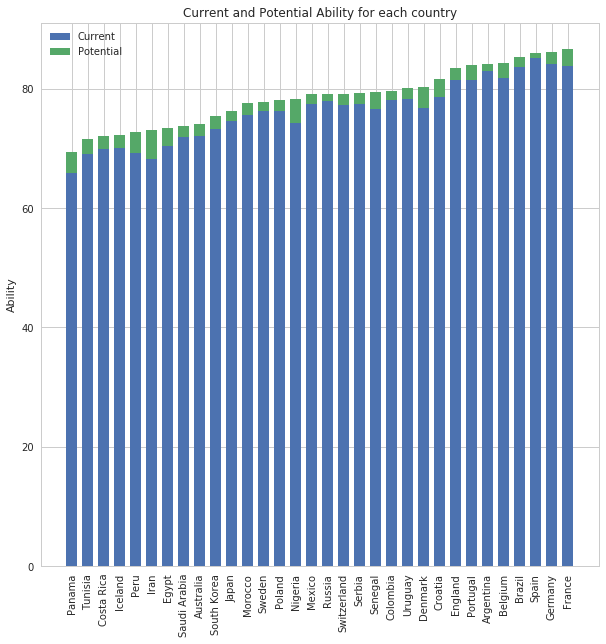

In [46]:
curr = grouped_wc_fifa18_stats["overall"]
pot = grouped_wc_fifa18_stats["Points_to_max_potential"]
ind = np.arange(32)
width = 0.7
plt.figure(figsize=(10,10))
p1 = plt.bar(ind,curr, width)
p2 = plt.bar(ind,pot, width, bottom=curr)

plt.ylabel('Ability')
plt.title('Current and Potential Ability for each country')
plt.xticks(ind,(grouped_wc_fifa18_stats.index),rotation=90)
plt.legend((p1[0], p2[0]), ('Current', 'Potential'))

plt.show()

We can see that France has the highest potential while Spain has the highest current ability.

# **6. Adding variables to build a poisson model**

We shall use the following variables of each country:

- Soccer Power Index
- Average Age
- Average Height
- Total World Cup Appearances
- Average goals scored per game
- Average goals conceded per game
- Potential

and compare it with the opponent to build a poisson distribution model to predict the number of goals scored. Detailed method will be explained below.

In [47]:
stats = stats.set_index("team",drop=True)
stats = stats.fillna(0)
stats["Ave_goals_scored_per_game"] = stats['total_worldcup_match_goals_scored'] / stats['total_world_cup_matches_played']
stats["Ave_goals_conceded_per_game"] = stats['total_worldcup_match_goals_against'] / stats['total_world_cup_matches_played']
stats["Potential"] = 0
for i in stats.index:
    stats.loc[i,"Potential"] = grouped_wc_fifa18_stats.loc[i,"potential"]
    
#Normalise the variables
for i in ["Soccer_power_index","Average_age","Average_height","total_worldcup_appearances","Potential"]:
    stats[i] = stats[i].apply(lambda x: (x - stats[i].mean())/stats[i].std())

stats = stats.loc[:,['Soccer_power_index','Average_age','Average_height','total_worldcup_appearances',"Ave_goals_scored_per_game","Ave_goals_conceded_per_game","Potential"]]
stats = stats.fillna(0)  #for panama and iceland (First time WC)

In [48]:
stats.head(5)

,Soccer_power_index,Average_age,Average_height,total_worldcup_appearances,Ave_goals_scored_per_game,Ave_goals_conceded_per_game,Potential
team,,,,,,,
Argentina,1.227822,1.032883,-1.034870,1.500040,1.701299,1.090909,1.156435
Australia,-1.043320,-0.412551,-0.237404,-0.715404,0.846154,2.000000,-0.908076
Belgium,1.067142,-0.316189,0.811894,0.761559,1.268293,1.609756,1.190844
Brazil,1.711526,0.454710,-0.615151,2.238521,2.125000,0.980769,1.404176
Colombia,0.617199,-0.027102,-0.699095,-0.530783,1.444444,1.500000,0.234287


# **7. Predicting World Cup 2018**

**Overall Method used**

1) XGBoost would be used first to predict just the result of the matches (Win,Lose,Draw) for the **group stages** as I am only interested in the match result and who progresses. Real results up to 23/06 was used. 

2) For the **elimination rounds onwards**, Logistic Regression (Lasso) model along with the poisson distribution would be used to predict the exact score.
    * Weight of 0.8 would be given to the poisson distribution and weight of 0.2 would be given to 
      the Logistic Regression (Lasso)
      
**Explanation on how I combine poisson distribution with Logistic Regression to predict the goals**

We shall use the method and formula:
- **Base goals** = Average goals scored from X against Y = max(Ave_goals_scored_per_game (X),                 
                                                               Ave_goals_conceded_per_game(Y))

- **difference in countries** = 0.4 * (diff. in Soccer_Power_index) + 
                              0.25 * (diff. in Potential) +
                              0.25 * (diff. in total_worldcup_appearances) +
                              0.05 * (diff. in Average_height) -
                              0.05 * (diff. in Average_age)
                              
    E.g diff in Soccer_Power_index --> Soccer_Power_index (X) - Soccer_Power_index (Y)

    Most weight (0.4) is given to difference in soccer power index because I feel it is the main   determining factor of a soccer match. 
    The potential of the players and the experience (total_worldcup_experience) would also play a important role in a match, especially in a semi-final/final. 
    Least weights were given to the height (Headers advantage) and age (might be correlated with their stamina) as they might play a small part in some parts of the match. Age difference was "subtracted" because the younger the player is, there is a higher change of having more stamina, hence lower age is "better". 

- **Mean goals scored from X against Y** = Max(0, Base goals + difference in countries)**

A poisson distribution would then be used to calculate the probability of them scoring 0,1,2,3,4,5,6 goals and combined with the classification models used to predict the number of goals for the match. 

**Combining poisson distribution with logistic regression together**

1) Using the mean goals scored from Home side against Away side (Calculated as above), we can generate a list of probabilities of Home Side scoring 0 - 6 goals against the Away side. 
    
    e.g [ Prob(0 goals), Prob(1 Goal), Prob(2Goals)....Prob(6 goals)]
    
2) We then use the Logistic Regression (Lasso) Model to generate a list of probabilities of Home Side scoring 0-6 goals against the Away Side. 

    e.g [ Prob(0 goals), Prob(1 Goal), Prob(2Goals)....Prob(6 goals)]
    
3) We then combine the probabilities by multiplying the poisson probabilities by 0.8 and logistic regression probabilities by 0.2 (More weight is given to poisson probabilities as I feel they are more accurate and stronger compared to the logistic regression models).

    e.g Prob (0 goals) = 0.8 * Poisson Probability (0 goals) + 0.2 * Logisti Regression Probability(0 goals)
    etc
    etc

4) Our prediction for the number of goals scored by the home side against the away side would be the one with the highest probability.

5) Repeat step 1-4 for the away side. 
    
    

**Group Stage Matches**

In [49]:
from itertools import combinations
#variables: ["country","impt","home_rank_change","away_rank_change","diff_in_ranking","diff_in_mean_weighted_over_years"]
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        
        if (home + "," + away) in list(results_so_far["Matches"]):
            real_result = results_so_far[results_so_far["Matches"] == (home + "," + away)]
            real_result.reset_index(inplace=True,drop=True)
            real_result = real_result.loc[0,"Result"]
            world_cup.loc[home, 'total_prob'] += 1
            world_cup.loc[away, 'total_prob'] += 1
            if real_result == 0:
                print("{} wins ".format(away))
                world_cup.loc[away, 'points'] += 3
                continue
            elif real_result == 1:
                points = 1
                print("Draw")
                world_cup.loc[home, 'points'] += 1
                world_cup.loc[away, 'points'] += 1
                continue
            elif real_result == 2:
                points = 3
                world_cup.loc[home, 'points'] += 3
                print("{} wins ".format(home))
                continue
        
        
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan]]), columns=x_test.columns)
        home_rank = rankings_18.loc[home,"rank"]
        away_rank =  rankings_18.loc[away,"rank"]
        

        row["country"] = 2 if home == "Russia" else 0
        row["impt"] = 1
        row["home_rank_change"] = rankings_18.loc[home,"rank"] - rankings_prev.loc[home,"rank"]
        row["away_rank_change"] = rankings_18.loc[away,"rank"] - rankings_prev.loc[away,"rank"]
        row['diff_in_ranking'] = home_rank - away_rank
        row["diff_in_mean_weighted_over_years"] = rankings_18.loc[home,"mean_weighted_over_years"] - rankings_18.loc[away,"mean_weighted_over_years"]
        
        home_win_prob = xgclass.predict_proba(row)[:,2][0]
        away_win_prob = xgclass.predict_proba(row)[:,0][0]
        draw_prob = xgclass.predict_proba(row)[:,1][0]

        
        points = 0
        if max(home_win_prob,away_win_prob,draw_prob) == away_win_prob:
            print("{} wins with {:.2f}".format(away, away_win_prob))
            world_cup.loc[away, 'points'] += 3
            world_cup.loc[home, 'total_prob'] += home_win_prob
            world_cup.loc[away, 'total_prob'] += away_win_prob
        if max(home_win_prob,away_win_prob,draw_prob) == draw_prob:
            points = 1
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            world_cup.loc[home, 'total_prob'] += draw_prob
            world_cup.loc[away, 'total_prob'] += draw_prob
        if max(home_win_prob,away_win_prob,draw_prob) == home_win_prob:
            points = 3
            world_cup.loc[home, 'points'] += 3
            world_cup.loc[home, 'total_prob'] += home_win_prob
            world_cup.loc[away, 'total_prob'] += away_win_prob
            print("{} wins with {:.2f}".format(home, home_win_prob))

___Starting group F:___
Germany vs. Mexico: Mexico wins 
Germany vs. Sweden: Sweden wins with 0.38
Germany vs. South Korea: Germany wins with 0.75
Mexico vs. Sweden: Mexico wins with 0.74
Mexico vs. South Korea: Mexico wins with 0.58
Sweden vs. South Korea: Sweden wins with 0.83
___Starting group E:___
Brazil vs. Switzerland: Draw
Brazil vs. Costa Rica: Brazil wins 
Brazil vs. Serbia: Brazil wins with 0.83
Switzerland vs. Costa Rica: Switzerland wins with 0.77
Switzerland vs. Serbia: Switzerland wins with 0.71
Costa Rica vs. Serbia: Serbia wins 
___Starting group C:___
France vs. Australia: France wins 
France vs. Peru: France wins 
France vs. Denmark: Draw
Australia vs. Peru: Draw
Australia vs. Denmark: Denmark wins with 0.84
Peru vs. Denmark: Denmark wins 
___Starting group B:___
Portugal vs. Spain: Draw
Portugal vs. Morocco: Portugal wins 
Portugal vs. Iran: Portugal wins with 0.41
Spain vs. Morocco: Spain wins with 0.83
Spain vs. Iran: Spain wins with 0.68
Morocco vs. Iran: Iran wi

In [50]:
world_cup

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay,7,2.660040
Saudi Arabia,A,Russia,Uruguay,Egypt,0,1.192720
Egypt,A,Uruguay,Russia,Saudi Arabia,3,2.718916
Uruguay,A,Egypt,Saudi Arabia,Russia,7,2.346988
Portugal,B,Spain,Morocco,Iran,7,2.410713
Spain,B,Portugal,Iran,Morocco,7,2.507417
Morocco,B,Iran,Portugal,Spain,0,2.111250
Iran,B,Morocco,Spain,Portugal,3,1.457949
France,C,Australia,Peru,Denmark,7,2.647991


**Elimination Round**

In [51]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]  # pair up for round-of-16

labels = []
odds = []

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal']

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan]]), columns=x_test.columns)
        home_rank = rankings_18.loc[home,"rank"]
        away_rank =  rankings_18.loc[away,"rank"]


        row["country"] = 2 if home == "Russia" else 0
        row["impt"] = 1
        row["home_rank_change"] = rankings_18.loc[home,"rank"] - rankings_prev.loc[home,"rank"]
        row["away_rank_change"] = rankings_18.loc[away,"rank"] - rankings_prev.loc[away,"rank"]
        row['diff_in_ranking'] = home_rank - away_rank
        row["diff_in_mean_weighted_over_years"] = rankings_18.loc[home,"mean_weighted_over_years"] - rankings_18.loc[away,"mean_weighted_over_years"]
        base_home_goals = max(stats.loc[home,"Ave_goals_scored_per_game"],stats.loc[away,"Ave_goals_conceded_per_game"])
        base_away_goals = max(stats.loc[away,"Ave_goals_scored_per_game"],stats.loc[home,"Ave_goals_conceded_per_game"])
        home_diff_in_countries = (0.4 * (stats.loc[home,"Soccer_power_index"] - stats.loc[away,"Soccer_power_index"]) +
                                  0.25 * (stats.loc[home,"Potential"] - stats.loc[away,"Potential"]) +
                                  0.25 * (stats.loc[home,"total_worldcup_appearances"] - stats.loc[away,"total_worldcup_appearances"]) +
                                  0.05 * (stats.loc[home,"Average_height"] - stats.loc[away,"Average_height"]) -
                                  0.05 * (stats.loc[home,"Average_age"] - stats.loc[away,"Average_age"]))
        away_diff_in_countries = (0.4 * (stats.loc[away,"Soccer_power_index"] - stats.loc[home,"Soccer_power_index"]) +
                                  0.25 * (stats.loc[away,"Potential"] - stats.loc[home,"Potential"]) +
                                  0.25 * (stats.loc[away,"total_worldcup_appearances"] - stats.loc[home,"total_worldcup_appearances"]) +
                                  0.05 * (stats.loc[away,"Average_height"] - stats.loc[home,"Average_height"]) -
                                  0.05 * (stats.loc[away,"Average_age"] - stats.loc[home,"Average_age"]))

        mean_home_goals = max(0,base_home_goals + home_diff_in_countries)   #max (0,goals) because cant be negative goals
        mean_away_goals = max(0,base_away_goals + away_diff_in_countries) 

        home_prob_of_goals = []
        home_prob_of_goals_logmodel = list(homelog_reg1.predict_proba(row)[0])
        away_prob_of_goals = []
        away_prob_of_goals_logmodel = list(awaylog_reg1.predict_proba(row)[0])
        for i in range(7):
            home_prob_of_goals.append(0.8 * poisson.pmf(i, mean_home_goals) + 0.2 * home_prob_of_goals_logmodel[i])
            away_prob_of_goals.append(0.8 * poisson.pmf(i, mean_away_goals) + 0.2 * away_prob_of_goals_logmodel[i])


        home_goals = np.argmax(home_prob_of_goals)
        away_goals = np.argmax(away_prob_of_goals)
        if home_goals > away_goals:
            print("{} wins {} with score of {}:{}".format(home,away,str(home_goals),str(away_goals)),end='')
            winners.append(home)

        elif home_goals < away_goals:
            print("{} wins {} with score of {}:{}".format(away,home,str(away_goals),str(home_goals)),end='')
            winners.append(away)

        else:
            team=[home,away]
            win = random.choice(team)
            print("{} draws with {} with a score of {}:{} after extra time and {} wins the penalty shootout".format(home,away,str(home_goals),str(away_goals),win))
            winners.append(win)
        print("\n")
print("Top 4: " + winners[0]+ "," + winners[1] + "," + winners[2] + "," +winners[3])

___Starting of the round_of_16___
Russia vs. Portugal: Portugal wins Russia with score of 2:1

France vs. Croatia: France wins Croatia with score of 2:0

Brazil vs. Sweden: Brazil wins Sweden with score of 2:0

England vs. Senegal: England wins Senegal with score of 2:0

Uruguay vs. Spain: Spain wins Uruguay with score of 2:0

Denmark vs. Iceland: Denmark wins Iceland with score of 2:0

Switzerland vs. Mexico: Switzerland draws with Mexico with a score of 1:1 after extra time and Mexico wins the penalty shootout


Belgium vs. Poland: Belgium wins Poland with score of 2:0

___Starting of the quarterfinal___
Russia vs. Portugal: Portugal wins Russia with score of 2:1

France vs. Croatia: France wins Croatia with score of 2:0

Brazil vs. Sweden: Brazil wins Sweden with score of 2:0

England vs. Senegal: England wins Senegal with score of 2:0

Uruguay vs. Spain: Spain wins Uruguay with score of 2:0

Denmark vs. Iceland: Denmark wins Iceland with score of 2:0

Switzerland vs. Mexico: Switze

**Predict exact scores for the final and 3rd place play-off**

In [52]:
import random
labels = []
odds = []
home_sides = winners[:2]
away_sides = winners[2:]
winner = []
loser = []
print("__Starting of the Semifinal__")
for i in range(2):
    home = home_sides[i]
    away = away_sides[i]
    print("{} vs. {}: ".format(home,
                                away), 
                                end='')
    row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan]]), columns=x_home_test.columns)
    home_rank = rankings_18.loc[home,"rank"]
    away_rank =  rankings_18.loc[away,"rank"]
    row["country"] = 0
    row["impt"] = 1
    row["home_rank_change"] = rankings_18.loc[home,"rank"] - rankings_prev.loc[home,"rank"]
    row["away_rank_change"] = rankings_18.loc[away,"rank"] - rankings_prev.loc[away,"rank"]
    row['diff_in_ranking'] = home_rank - away_rank
    row["diff_in_mean_weighted_over_years"] = rankings_18.loc[home,"mean_weighted_over_years"] - rankings_18.loc[away,"mean_weighted_over_years"]
    base_home_goals = max(stats.loc[home,"Ave_goals_scored_per_game"],stats.loc[away,"Ave_goals_conceded_per_game"])
    base_away_goals = max(stats.loc[away,"Ave_goals_scored_per_game"],stats.loc[home,"Ave_goals_conceded_per_game"])
    home_diff_in_countries = (0.4 * (stats.loc[home,"Soccer_power_index"] - stats.loc[away,"Soccer_power_index"]) +
                              0.25 * (stats.loc[home,"Potential"] - stats.loc[away,"Potential"]) +
                              0.25 * (stats.loc[home,"total_worldcup_appearances"] - stats.loc[away,"total_worldcup_appearances"]) +
                              0.05 * (stats.loc[home,"Average_height"] - stats.loc[away,"Average_height"]) -
                              0.05 * (stats.loc[home,"Average_age"] - stats.loc[away,"Average_age"]))
    away_diff_in_countries = (0.4 * (stats.loc[away,"Soccer_power_index"] - stats.loc[home,"Soccer_power_index"]) +
                              0.25 * (stats.loc[away,"Potential"] - stats.loc[home,"Potential"]) +
                              0.25 * (stats.loc[away,"total_worldcup_appearances"] - stats.loc[home,"total_worldcup_appearances"]) +
                              0.05 * (stats.loc[away,"Average_height"] - stats.loc[home,"Average_height"]) -
                              0.05 * (stats.loc[away,"Average_age"] - stats.loc[home,"Average_age"]))
    
    mean_home_goals = max(0,base_home_goals + home_diff_in_countries)   #max (0,goals) because cant be negative goals
    mean_away_goals = max(0,base_away_goals + away_diff_in_countries) 
    
    home_prob_of_goals = []
    home_prob_of_goals_logmodel = list(homelog_reg1.predict_proba(row)[0])
    away_prob_of_goals = []
    away_prob_of_goals_logmodel = list(awaylog_reg1.predict_proba(row)[0])
    for i in range(7):
        home_prob_of_goals.append(0.8 * poisson.pmf(i, mean_home_goals) + 0.2 * home_prob_of_goals_logmodel[i])
        away_prob_of_goals.append(0.8 * poisson.pmf(i, mean_away_goals) + 0.2 * away_prob_of_goals_logmodel[i])
        

    home_goals = np.argmax(home_prob_of_goals)
    away_goals = np.argmax(away_prob_of_goals)
    if home_goals > away_goals:
        print("{} wins {} with score of {}:{}".format(home,away,str(home_goals),str(away_goals)),end='')
        winner.append(home)
        loser.append(away)
    elif home_goals < away_goals:
        print("{} wins {} with score of {}:{}".format(away,home,str(away_goals),str(home_goals)),end='')
        winner.append(away)
        loser.append(home)
    else:
        team=[home,away]
        win = random.choice(team)
        team.remove(win)
        lose = team[0]
        print("{} draws with {} with a score of {}:{} after extra time and {} wins the penalty shootout".format(home,away,str(home_goals),str(away_goals),win))
        winner.append(win)
        loser.append(lose)
    print("\n")
print("__Third place playoff__")
home = loser[0]
away = loser[1]
print("{} vs. {}: ".format(home,
                            away), 
                            end='')
row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan]]), columns=x_home_test.columns)
home_rank = rankings_18.loc[home,"rank"]
away_rank =  rankings_18.loc[away,"rank"]
row["country"] = 0
row["impt"] = 1
row["home_rank_change"] = rankings_18.loc[home,"rank"] - rankings_prev.loc[home,"rank"]
row["away_rank_change"] = rankings_18.loc[away,"rank"] - rankings_prev.loc[away,"rank"]
row['diff_in_ranking'] = home_rank - away_rank
row["diff_in_mean_weighted_over_years"] = rankings_18.loc[home,"mean_weighted_over_years"] - rankings_18.loc[away,"mean_weighted_over_years"]
base_home_goals = max(stats.loc[home,"Ave_goals_scored_per_game"],stats.loc[away,"Ave_goals_conceded_per_game"])
base_away_goals = max(stats.loc[away,"Ave_goals_scored_per_game"],stats.loc[home,"Ave_goals_conceded_per_game"])
home_diff_in_countries = (0.4 * (stats.loc[home,"Soccer_power_index"] - stats.loc[away,"Soccer_power_index"]) +
                          0.25 * (stats.loc[home,"Potential"] - stats.loc[away,"Potential"]) +
                          0.25 * (stats.loc[home,"total_worldcup_appearances"] - stats.loc[away,"total_worldcup_appearances"]) +
                          0.05 * (stats.loc[home,"Average_height"] - stats.loc[away,"Average_height"]) -
                          0.05 * (stats.loc[home,"Average_age"] - stats.loc[away,"Average_age"]))
away_diff_in_countries = (0.4 * (stats.loc[away,"Soccer_power_index"] - stats.loc[home,"Soccer_power_index"]) +
                          0.25 * (stats.loc[away,"Potential"] - stats.loc[home,"Potential"]) +
                          0.25 * (stats.loc[away,"total_worldcup_appearances"] - stats.loc[home,"total_worldcup_appearances"]) +
                          0.05 * (stats.loc[away,"Average_height"] - stats.loc[home,"Average_height"]) -
                          0.05 * (stats.loc[away,"Average_age"] - stats.loc[home,"Average_age"]))
    
mean_home_goals = max(0,base_home_goals + home_diff_in_countries)   #max (0,goals) because cant be negative goals
mean_away_goals = max(0,base_away_goals + away_diff_in_countries) 
    
home_prob_of_goals = []
home_prob_of_goals_logmodel = list(homelog_reg1.predict_proba(row)[0])
away_prob_of_goals = []
away_prob_of_goals_logmodel = list(awaylog_reg1.predict_proba(row)[0])
for i in range(7):
    home_prob_of_goals.append(0.8 * poisson.pmf(i, mean_home_goals) + 0.2 * home_prob_of_goals_logmodel[i])
    away_prob_of_goals.append(0.8 * poisson.pmf(i, mean_away_goals) + 0.2 * away_prob_of_goals_logmodel[i])
        

home_goals = np.argmax(home_prob_of_goals)
away_goals = np.argmax(away_prob_of_goals)
if home_goals > away_goals:
    print("{} wins {} with score of {}:{}".format(home,away,str(home_goals),str(away_goals)),end='')

elif home_goals < away_goals:
    print("{} wins {} with score of {}:{}".format(away,home,str(away_goals),str(home_goals)),end='')

else:
    team=[home,away]
    win = random.choice(team)
    team.remove(win)
    lose = team[0]
    print("{} draws with {} with a score of {}:{} after extra time and {} wins the penalty shootout".format(home,away,str(home_goals),str(away_goals),win))

print("\n")
print("__World Cup Final__")
home = winner[0]
away = winner[1]
print("{} vs. {}: ".format(home,
                            away), 
                            end='')
row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan]]), columns=x_home_test.columns)
home_rank = rankings_18.loc[home,"rank"]
away_rank =  rankings_18.loc[away,"rank"]
row["country"] = 0
row["impt"] = 1
row["home_rank_change"] = rankings_18.loc[home,"rank"] - rankings_prev.loc[home,"rank"]
row["away_rank_change"] = rankings_18.loc[away,"rank"] - rankings_prev.loc[away,"rank"]
row['diff_in_ranking'] = home_rank - away_rank
row["diff_in_mean_weighted_over_years"] = rankings_18.loc[home,"mean_weighted_over_years"] - rankings_18.loc[away,"mean_weighted_over_years"]
base_home_goals = max(stats.loc[home,"Ave_goals_scored_per_game"],stats.loc[away,"Ave_goals_conceded_per_game"])
base_away_goals = max(stats.loc[away,"Ave_goals_scored_per_game"],stats.loc[home,"Ave_goals_conceded_per_game"])
home_diff_in_countries = (0.4 * (stats.loc[home,"Soccer_power_index"] - stats.loc[away,"Soccer_power_index"]) +
                          0.25 * (stats.loc[home,"Potential"] - stats.loc[away,"Potential"]) +
                          0.25 * (stats.loc[home,"total_worldcup_appearances"] - stats.loc[away,"total_worldcup_appearances"]) +
                          0.05 * (stats.loc[home,"Average_height"] - stats.loc[away,"Average_height"]) -
                          0.05 * (stats.loc[home,"Average_age"] - stats.loc[away,"Average_age"]))
away_diff_in_countries = (0.4 * (stats.loc[away,"Soccer_power_index"] - stats.loc[home,"Soccer_power_index"]) +
                          0.25 * (stats.loc[away,"Potential"] - stats.loc[home,"Potential"]) +
                          0.25 * (stats.loc[away,"total_worldcup_appearances"] - stats.loc[home,"total_worldcup_appearances"]) +
                          0.05 * (stats.loc[away,"Average_height"] - stats.loc[home,"Average_height"]) -
                          0.05 * (stats.loc[away,"Average_age"] - stats.loc[home,"Average_age"]))
    
mean_home_goals = max(0,base_home_goals + home_diff_in_countries)   #max (0,goals) because cant be negative goals
mean_away_goals = max(0,base_away_goals + away_diff_in_countries) 
    
home_prob_of_goals = []
home_prob_of_goals_logmodel = list(homelog_reg1.predict_proba(row)[0])
away_prob_of_goals = []
away_prob_of_goals_logmodel = list(awaylog_reg1.predict_proba(row)[0])
for i in range(7):
    home_prob_of_goals.append(0.8 * poisson.pmf(i, mean_home_goals) + 0.2 * home_prob_of_goals_logmodel[i])
    away_prob_of_goals.append(0.8 * poisson.pmf(i, mean_away_goals) + 0.2 * away_prob_of_goals_logmodel[i])
        

home_goals = np.argmax(home_prob_of_goals)
away_goals = np.argmax(away_prob_of_goals)
if home_goals > away_goals:
    print("{} wins {} with score of {}:{}".format(home,away,str(home_goals),str(away_goals)),end='')

elif home_goals < away_goals:
    print("{} wins {} with score of {}:{}".format(away,home,str(away_goals),str(home_goals)),end='')

else:
    team=[home,away]
    win = random.choice(team)
    team.remove(win)
    lose = team[0]
    print("{} draws with {} with a score of {}:{} after extra time and {} wins the penalty shootout".format(home,away,str(home_goals),str(away_goals),win))


__Starting of the Semifinal__
Portugal vs. Brazil: Brazil wins Portugal with score of 3:0

France vs. England: France draws with England with a score of 1:1 after extra time and France wins the penalty shootout


__Third place playoff__
Portugal vs. England: Portugal draws with England with a score of 1:1 after extra time and Portugal wins the penalty shootout


__World Cup Final__
Brazil vs. France: Brazil wins France with score of 2:1

**Predictions:**

**Winner**: Brazil

**2nd Place**: France

**3rd Place**: Portugal

**Final Score**: Brazil vs France: 2-1

**Third place playoff score**: Portugal vs England: 1-1 , with Portugal winning the penalty shootout (possibly with Ronaldo scoring the winning penalty ;) )